L'objectif de ce notebook est de vous présenter une application pratique de modélisation d'une série temporelle avec le modèle ARIMA. Les données utilisées sont les données du package statsmodels de python.


## Importer les librairies

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

Charger les données:

In [116]:
data = sm.datasets.get_rdataset("AirPassengers", package="datasets")
df = data.data
df["Annee_mois"] = pd.date_range(start="1949-01", periods=len(df), freq="ME")  # Conversion en série temporelle
df["Annee"]=df["Annee_mois"].dt.year
df.set_index("Annee_mois", inplace=True)

## Visualisation

In [ ]:
df.head()

In [ ]:
df.tail(6)

In [117]:
df.isnull().sum()

time     0
value    0
Annee    0
dtype: int64

In [118]:
df_passager = df[['value']]

In [119]:
df_passager.tail(2)

,value
Annee_mois,
1960-11-30,390
1960-12-31,432


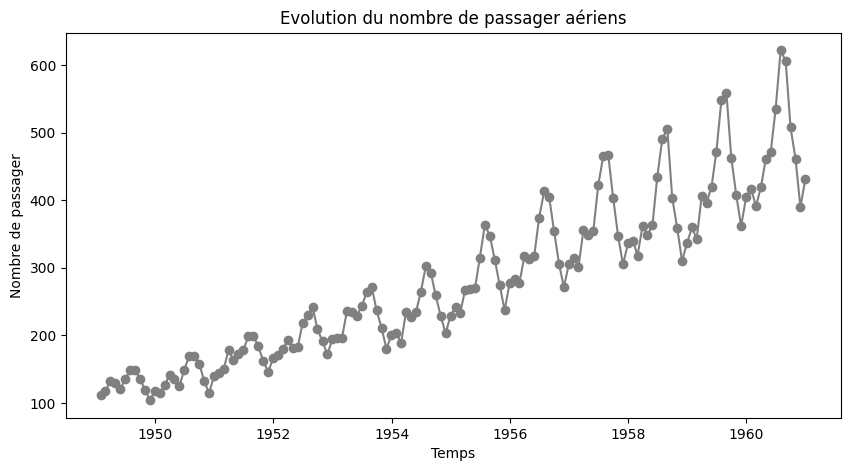

In [120]:
plt.figure(figsize=(10,5))
plt.plot(df_passager, label="Nombre de Passagers", marker='o', linestyle='-', color='grey')
plt.title("Evolution du nombre de passager aériens")
plt.xlabel("Temps")
plt.ylabel("Nombre de passager")
plt.show()

On constate clairement que notre série a une tendance linéaire et saisonnière. Ce modèle est-il additif ou multiplicatif?

## On va le vérifier en utilisant la méthode de buys-ballot:

In [121]:
df_buys_ballot= df.groupby("Annee")["value"].agg(Moyenne='mean',Ecart_type='std').reset_index() # moyenne et variance sur une période

In [122]:
df_buys_ballot

,Annee,Moyenne,Ecart_type
0,1949,126.666667,13.720147
1,1950,139.666667,19.070841
2,1951,170.166667,18.438267
3,1952,197.000000,22.966379
4,1953,225.000000,28.466887
5,1954,238.916667,34.924486
6,1955,284.000000,42.140458
7,1956,328.250000,47.861780
8,1957,368.416667,57.890898
9,1958,381.000000,64.530472


Nuage de points:

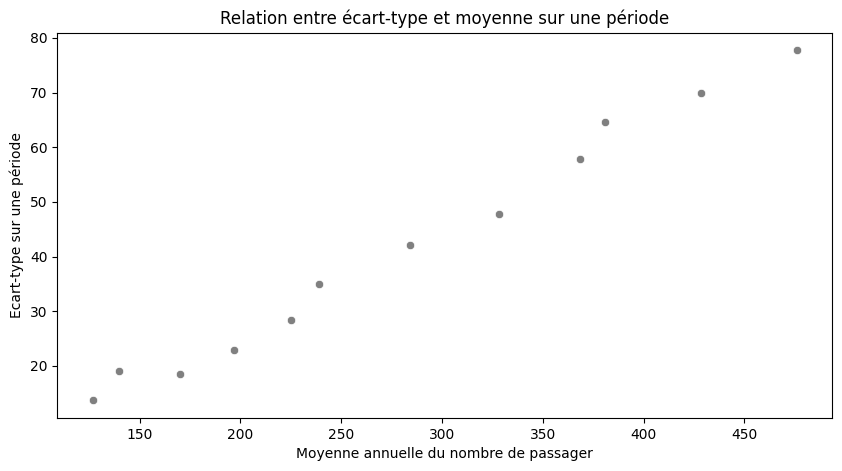

In [123]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df_buys_ballot["Moyenne"],y=df_buys_ballot["Ecart_type"], color="grey")
plt.xlabel("Moyenne annuelle du nombre de passager")
plt.ylabel("Ecart-type sur une période")
plt.title("Relation entre écart-type et moyenne sur une période")
plt.show()

Estimer le modèle de régression linéaire:

In [124]:
X=df_buys_ballot['Moyenne']
y=df_buys_ballot['Ecart_type']
X=sm.add_constant(X) # modèle avec constante
model = sm.OLS(y,X).fit()

In [125]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Ecart_type   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     822.3
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           6.19e-11
Time:                        10:34:11   Log-Likelihood:                -27.062
No. Observations:                  12   AIC:                             58.12
Df Residuals:                      10   BIC:                             59.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.4033      1.983     -5.751      0.0

C:\Users\Isabelle LACMAGO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


Ajouter au graphe précedent la droite de régression:

In [126]:
df_buys_ballot['Prediction_ecart_type']=model.predict(X)

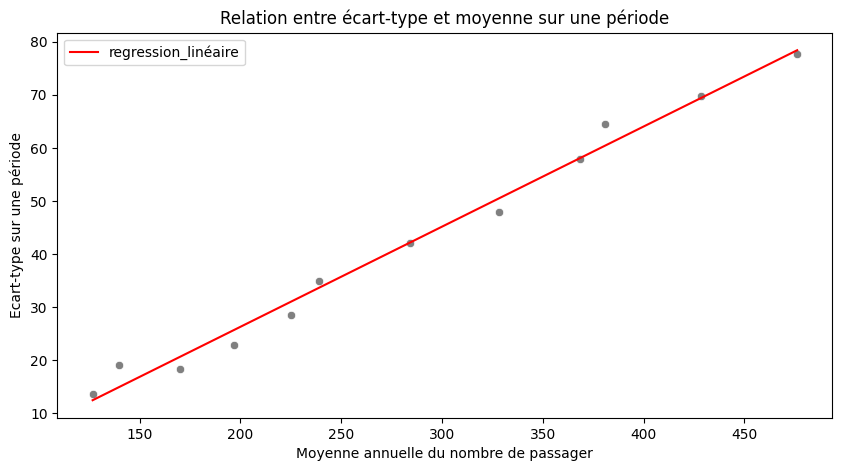

In [127]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df_buys_ballot["Moyenne"],y=df_buys_ballot["Ecart_type"], color="grey")
plt.xlabel("Moyenne annuelle du nombre de passager")
plt.ylabel("Ecart-type sur une période")
plt.title("Relation entre écart-type et moyenne sur une période")

plt.plot(df_buys_ballot["Moyenne"],df_buys_ballot["Prediction_ecart_type"], color="red", label="regression_linéaire")
plt.legend()
plt.show()

## Décomposer la série temporelle

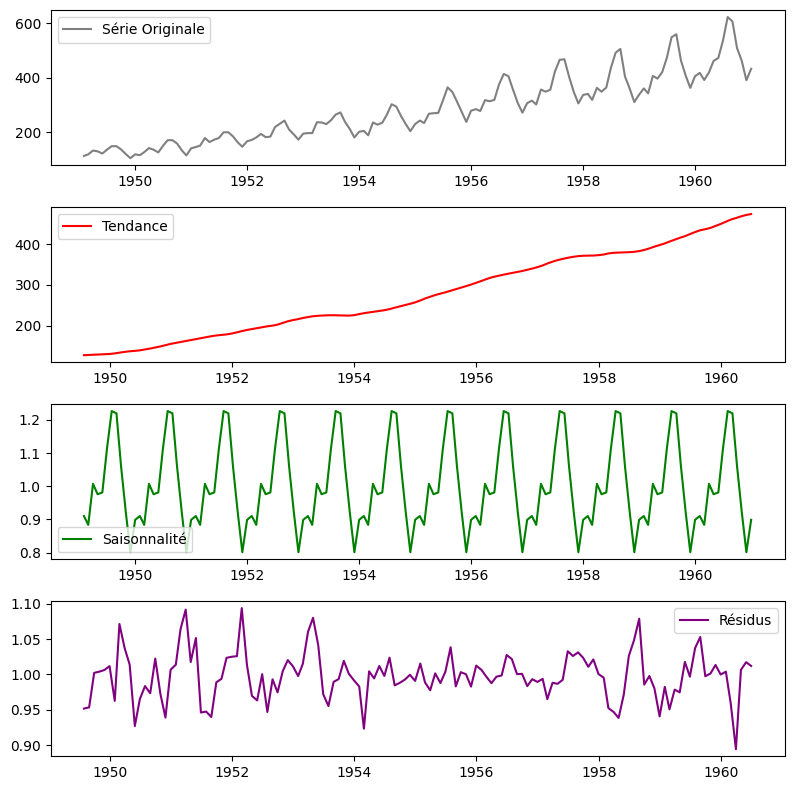

In [128]:


# Décomposer la série temporelle
decomposition = seasonal_decompose(df_passager, model="multiplicatif", period=12)  #  'period' est le nombre de données dans l'année

# Extraire les composantes
tendance = decomposition.trend
saison = decomposition.seasonal
Bruit = decomposition.resid

# Afficher les résultats
plt.figure(figsize=(8, 8))

plt.subplot(411)
plt.plot(df_passager, label="Série Originale", color="grey")
plt.legend()

plt.subplot(412)
plt.plot(tendance, label="Tendance", color="red")
plt.legend()

plt.subplot(413)
plt.plot(saison, label="Saisonnalité", color="green")
plt.legend()

plt.subplot(414)
plt.plot(Bruit, label="Résidus", color="purple")
plt.legend()

plt.tight_layout()
plt.show()


Vérifier l'autocorrélation:

In [129]:
bruit = Bruit.dropna()

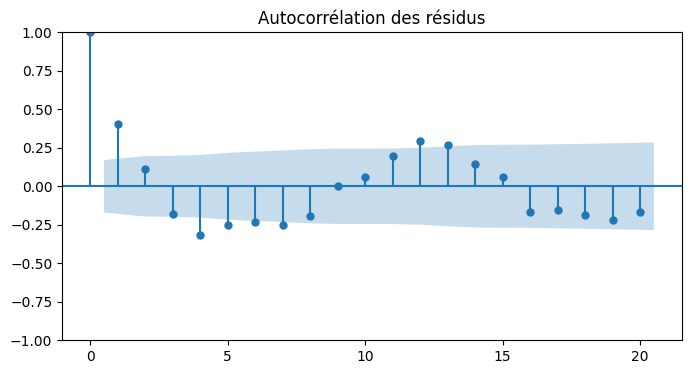

In [130]:
# Vérifier l'autocorrélation des résidus avec ACF
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(bruit, lags=20, ax=ax)
plt.title("Autocorrélation des résidus")
plt.show()

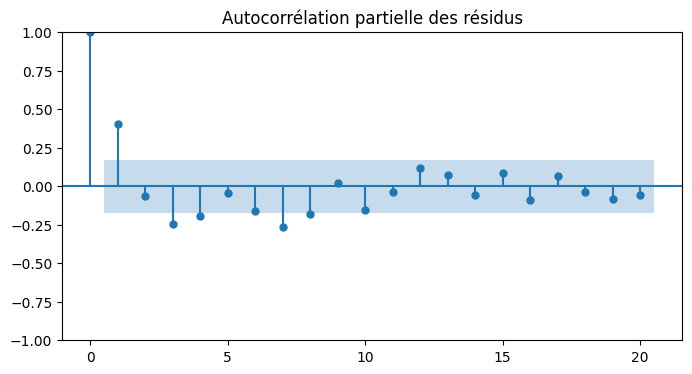

In [131]:
# Vérifier l'autocorrélation des résidus avec PACF
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_pacf(bruit, lags=20, ax=ax)
plt.title("Autocorrélation partielle des résidus")
plt.show()

In [133]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test de Ljung-Box
ljung_box_test = acorr_ljungbox(bruit, lags=[20], return_df=True)

print(ljung_box_test)

       lb_stat     lb_pvalue
20  131.532882  2.009192e-18


In [134]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(bruit)
print(f"Statistique de Durbin-Watson : {dw_stat}")

Statistique de Durbin-Watson : 0.001305406440261144


## Transformer la série pour avoir un modèle additif

In [138]:
def test_stationnarite(series):
    result = adfuller(series)
    print(f"Statistique de test : {result[0]}")
    print(f"P-valeur : {result[1]}")
    print("La série est stationnaire" if result[1] < 0.05 else "La série n'est PAS stationnaire")

In [135]:
df_passager["passager_ln"] = np.log(df_passager["value"])

C:\Users\Isabelle LACMAGO\AppData\Local\Temp\ipykernel_20564\2268366664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passager["passager_ln"] = np.log(df_passager["value"])


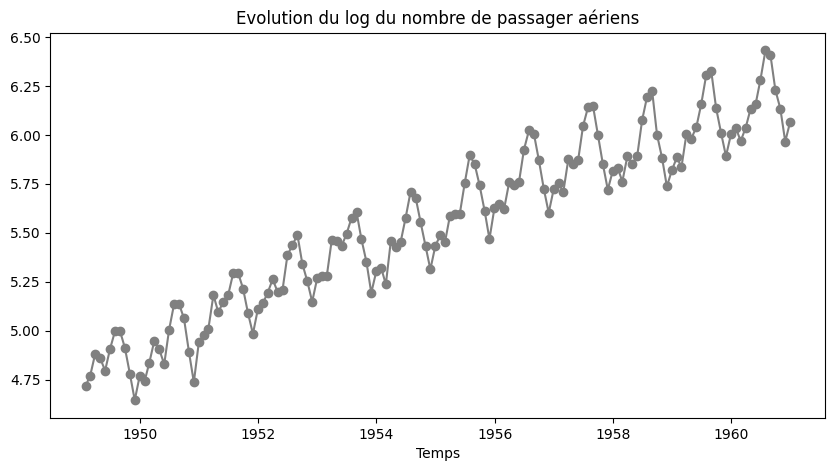

In [136]:
plt.figure(figsize=(10,5))
plt.plot(df_passager['passager_ln'], label="log du Nombre de Passagers", marker='o', linestyle='-', color='grey')
plt.title("Evolution du log du nombre de passager aériens")
plt.xlabel("Temps")
#plt.ylabel("Nombre de passager")
plt.show()

ACF:

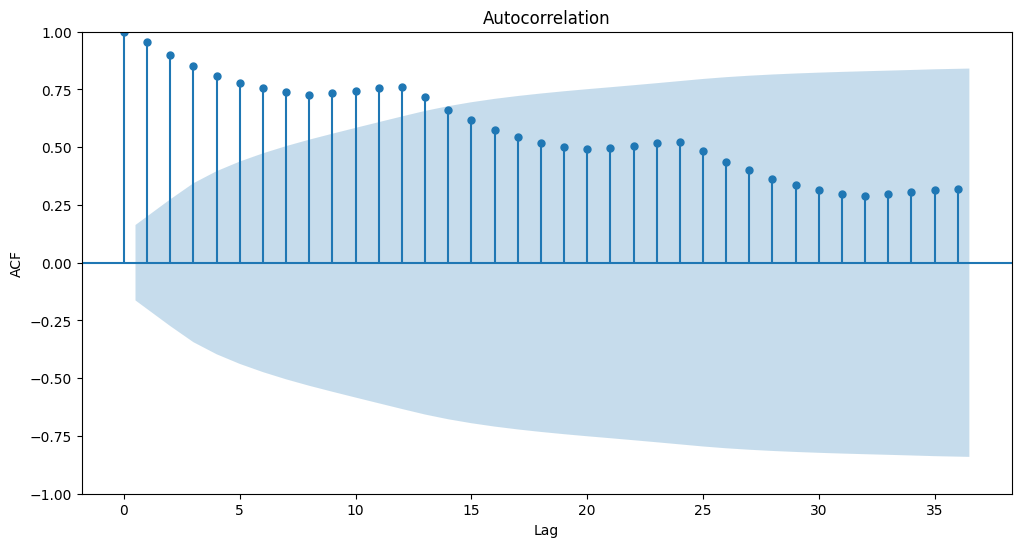

In [137]:
y = df_passager['passager_ln']
s, nlag = 12, 36
# Autocorrélation simple
fig, axe = plt.subplots(figsize=(12,6))
plot_acf(y,lags=nlag,ax=axe)
axe.set_xlabel("Lag")
axe.set_ylabel("ACF")
plt.show()

In [139]:
test_stationnarite(y)

Statistique de test : -1.717017089106963
P-valeur : 0.4223667747703902
La série n'est PAS stationnaire


On commence par tédendancialiser la série (premiière différence)

In [140]:
df_passager["passager_ln_diff"]=df_passager['passager_ln'].diff(1)

In [142]:
df_passager.head()

,value,passager_ln,passager_ln_diff
Annee_mois,,,
1949-01-31,112,4.718499,NaN
1949-02-28,118,4.770685,0.052186
1949-03-31,132,4.882802,0.112117
1949-04-30,129,4.859812,-0.022990
1949-05-31,121,4.795791,-0.064022


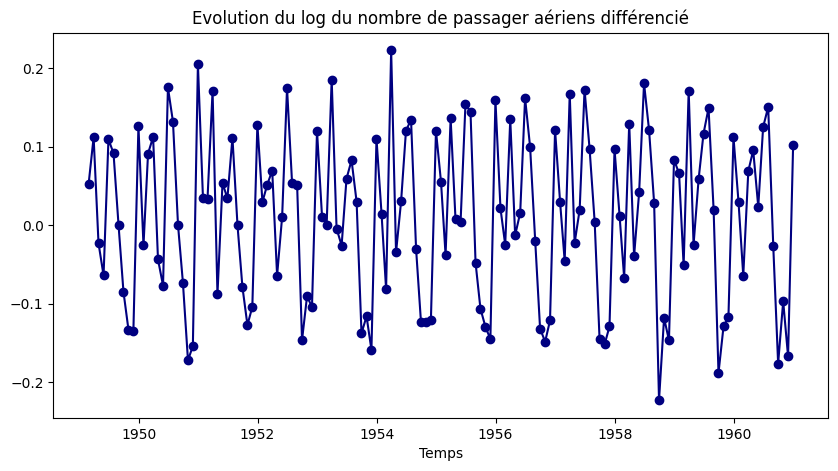

In [143]:
plt.figure(figsize=(10,5))
plt.plot(df_passager['passager_ln_diff'], label="log du Nombre de Passagers sans tendance", marker='o', linestyle='-', color='navy')
plt.title("Evolution du log du nombre de passager aériens différencié")
plt.xlabel("Temps")
plt.show()

On représente l'ACF

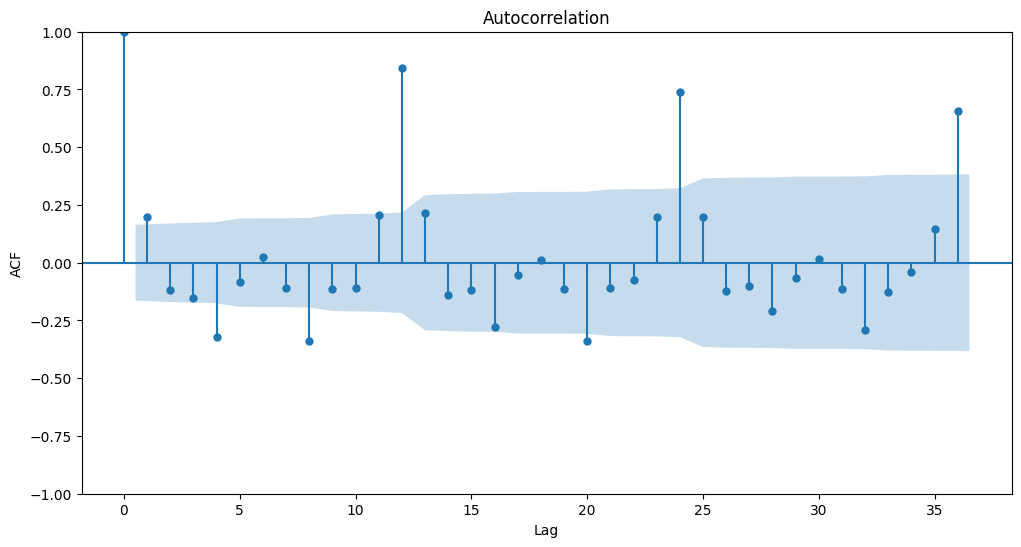

In [144]:
y = df_passager['passager_ln_diff'].dropna()
s, nlag = 12, 36
# Autocorrélation simple
fig, axe = plt.subplots(figsize=(12,6))
plot_acf(y,lags=nlag,ax=axe)
axe.set_xlabel("Lag")
axe.set_ylabel("ACF")
plt.show()

In [145]:
test_stationnarite(y)

Statistique de test : -2.717130598388136
P-valeur : 0.0711205481508582
La série n'est PAS stationnaire


Désaisonnaliser la série

In [146]:
df_passager["passager_ln_diff_sais"]=df_passager['passager_ln_diff'].diff(12)

On représente l'ACF

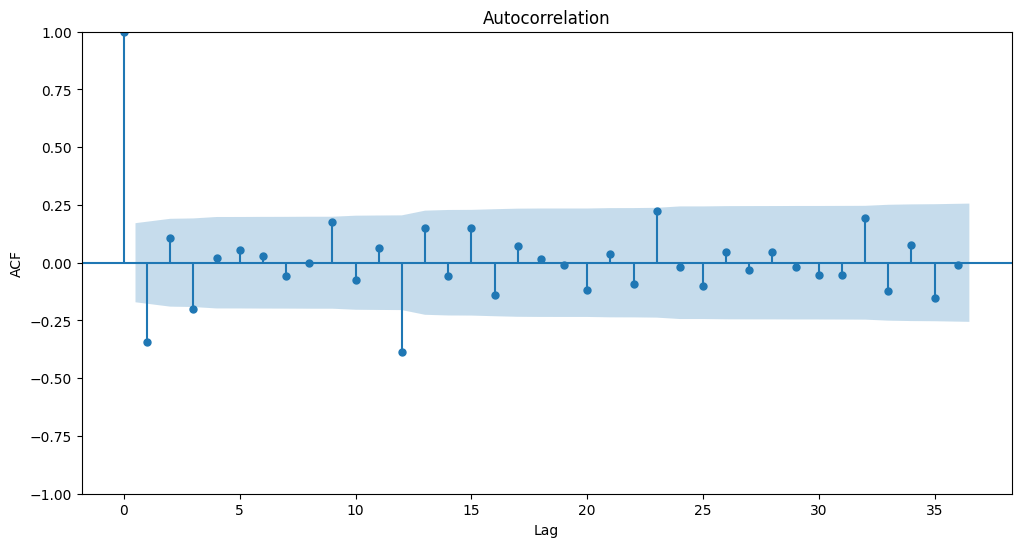

In [149]:
y = df_passager['passager_ln_diff_sais'].dropna()
s, nlag = 12, 36
# Autocorrélation simple
fig, axe = plt.subplots(figsize=(12,6))
plot_acf(y,lags=nlag,ax=axe)
axe.set_xlabel("Lag")
axe.set_ylabel("ACF")
plt.show()

In [150]:
test_stationnarite(y)

Statistique de test : -4.443324941831113
P-valeur : 0.00024859123113841515
La série est stationnaire


## Etape 0: Vérifier la stationnarité:

In [151]:
test_stationnarite(y)

Statistique de test : -4.443324941831113
P-valeur : 0.00024859123113841515
La série est stationnaire


## Identification du modèle

Se fait à partir de l'ACF et du PACF: de y=(I-B)(I-B^12)ln(Xt)

In [ ]:
s, nlag = 12, 36
# Autocorrélation simple
fig, axe = plt.subplots(figsize=(10,6))
plot_pacf(y,lags=nlag,ax=axe)
axe.set_xlabel("Lag")
axe.set_ylabel("PACF")
plt.show()

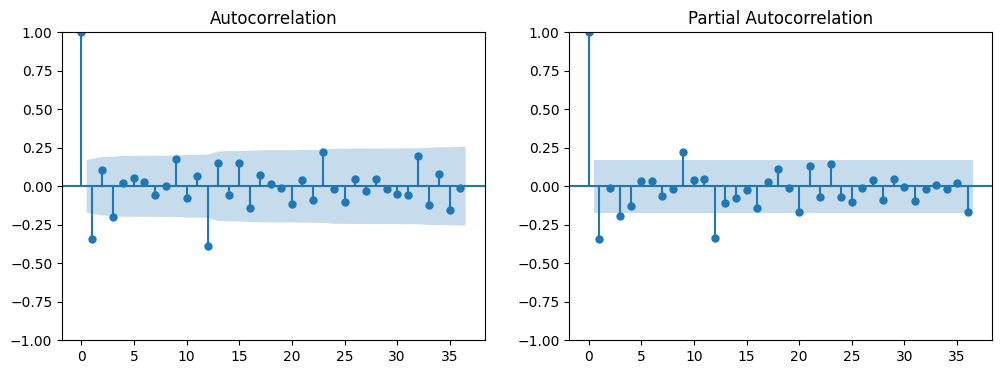

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y, lags=36, ax=ax[0])
plot_pacf(y, lags=36, ax=ax[1])
plt.show()

Identifier les valeur du modèle $SARIMA(p,d,q)(P,D,Q)_{12}$
 - Partie non saisonnière:
     - d=1
     - p=1
     - q=1 

 - Partie saisonière:
    - D=1
    - P=1
    - Q=1 

## Etape 2: Estimer les paramètres de notre série


In [153]:
#Estimation modèle 1:
#Estimationd'un SARIMA(1,1,1)(1,1,1)_{12}
model1 = ARIMA(y,order=(1,1,1),seasonal_order=(1, 1, 1,12)).fit()
print(model1.summary())
#model1_params =extractParams(model1,model_type= "arima")

C:\Users\Isabelle LACMAGO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Isabelle LACMAGO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Isabelle LACMAGO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:            passager_ln_diff_sais   No. Observations:                  131
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 191.305
Date:                          Thu, 06 Feb 2025   AIC                           -372.610
Time:                                  11:22:46   BIC                           -358.756
Sample:                              02-28-1950   HQIC                          -366.985
                                   - 12-31-1960                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3823      0.075     -5.074      0.000      -0.530      -0.235
ma.L1         -0.9868      0.217     -4.557      0.

In [155]:
#Estimation modèle 2:
#Estimationd'un SARIMA(1,1,1)(1,1,0)_{12}
model2 = ARIMA(y,order=(1,1,1),seasonal_order=(1, 1, 0,12)).fit()
print(model2.summary())

C:\Users\Isabelle LACMAGO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Isabelle LACMAGO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Isabelle LACMAGO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:             passager_ln_diff_sais   No. Observations:                  131
Model:             ARIMA(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 169.363
Date:                           Thu, 06 Feb 2025   AIC                           -330.725
Time:                                   11:27:56   BIC                           -319.642
Sample:                               02-28-1950   HQIC                          -326.225
                                    - 12-31-1960                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3646      0.078     -4.651      0.000      -0.518      -0.211
ma.L1         -0.9903      0.100     -9.908

## Etape 3:Validation du modèle retenu

In [156]:
residus = model2.resid

In [159]:
residus.head()

Annee_mois
1950-02-28    0.039164
1950-03-31   -0.038803
1950-04-30   -0.020856
1950-05-31    0.007556
1950-06-30    0.079088
dtype: float64

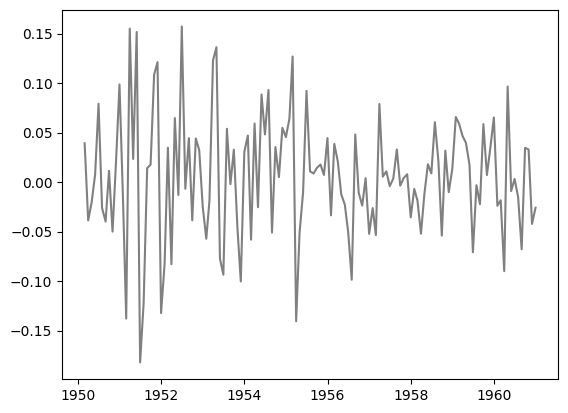

In [160]:
plt.plot(residus, color='grey')
plt.show()

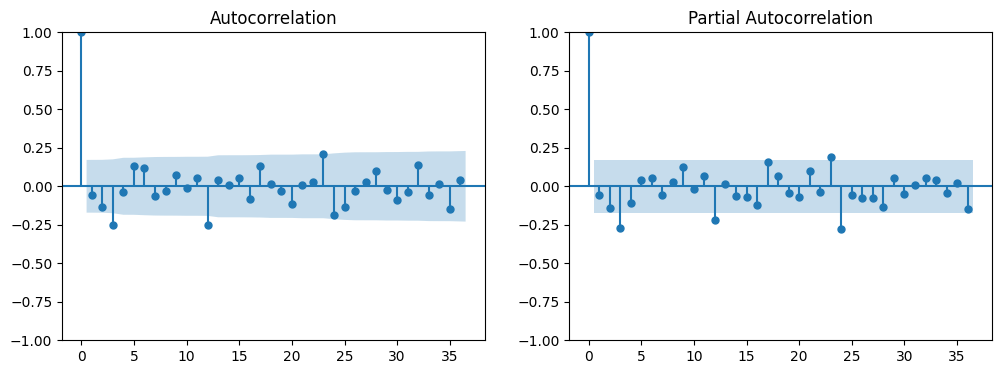

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residus, lags=36, ax=ax[0])
plot_pacf(residus, lags=36, ax=ax[1])
plt.show()

In [166]:
#test de ljung_box

ljung_box_test_resid = acorr_ljungbox(residus, lags=[24], return_df=True)
print(ljung_box_test_resid)

     lb_stat  lb_pvalue
24  46.10978   0.004294


In [169]:
#test de durbin durbin_watson
dw_stat=durbin_watson(residus)
print(f"Statisque du test de durbin watson:{dw_stat}")

Statisque du test de durbin watson:2.091475538873164


## Etape 4: Prédiction 

In [170]:
prediction_1961 = model2.forecast(steps=12)

In [172]:
prediction_1961

1961-01-31    1.028350
1961-02-28    1.004470
1961-03-31    0.996311
1961-04-30    1.047493
1961-05-31    0.999476
1961-06-30    0.958348
1961-07-31    1.018990
1961-08-31    0.979190
1961-09-30    1.026973
1961-10-31    1.001470
1961-11-30    1.003701
1961-12-31    1.015755
Freq: ME, Name: predicted_mean, dtype: float64